## Reference:

### 1) https://www.kaggle.com/akashravichandran/audiotag-eda

### 2) https://www.kaggle.com/dude431/beginner-s-visualization-and-removing-uniformative

### 3) https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai

## Import libraries

In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

from tqdm import tqdm
import wave
from scipy.io import wavfile
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display

from pathlib import Path
from tqdm import tqdm_notebook
import path
import IPython
from sklearn.preprocessing import minmax_scale
import warnings
warnings.filterwarnings("ignore")

from fastai import *
from fastai.vision import *
from fastai.vision.data import *
import random
# Any results you write to the current directory are saved as output.

['test', 'train_noisy.csv', 'train_curated.csv', 'train_curated', 'sample_submission.csv', 'train_noisy']


## Exploring the data

In [63]:
noisy_df = pd.read_csv('../input/train_noisy.csv')
curated_df = pd.read_csv('../input/train_curated.csv')

In [ ]:
noisy_df

### noisy_df contains all the sound files and the labels present in them.

In [ ]:
noisy_df.shape

In [ ]:
curated_df.head()

In [ ]:
curated_df.shape

## Function to play the .wav file

In [ ]:
IPython.display.Audio("../input/train_noisy/001f3501.wav")

In [ ]:
sample = pd.read_csv('../input/sample_submission.csv')

In [ ]:
sample.head()

## Distribution of categories

In [ ]:
plt.figure(figsize=(15,8))

# Store the 30 highest present labels in the dataframe
audio_type = curated_df["labels"].value_counts().head(30)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Top 30 labels with their frequencies in training data")
plt.show()

### We notice that labels Scissor, Gong and 4 more are the most common labels present

## Analyze the audio lengths

In [ ]:
train_new = curated_df.sort_values('labels').reset_index()

# Calculate the number of frames in an audio file
train_new["nframes"] = train_new["fname"].apply(lambda f: wave.open("../input/train_curated/" + f).getnframes())

train_fname = train_new.head(1000)

In [ ]:
train_new["nframes"].mean()

In [ ]:
train_new["nframes"].max()

In [ ]:
train_new["nframes"].min()

In [ ]:
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=train_fname)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

## Frame length distribution

In [ ]:
path = "../input/train_curated/"
fig, axes = plt.subplots(figsize=(16,5))
train_new.nframes.hist(bins=100)
plt.suptitle('Frame Length Distribution in Train Curated', ha='center', fontsize='large');

### Most of the audio files are small and are in the range of 0-5 seconds time interval

### Assessing the waveform of the audio files

In [ ]:
show_df = curated_df.sort_values('labels')
labels = show_df["labels"].unique()


In [ ]:
show_df.head()

In [ ]:
labels

In [ ]:
len(labels)

In [ ]:
TRAIN_PATH = '../input/train_curated/'
train_ids = next(os.walk(TRAIN_PATH))[2]
train_ids[0]

In [ ]:
len(train_ids)

In [ ]:
train_ids

In [ ]:
IPython.display.Audio(TRAIN_PATH + train_ids[0])
IPython.display.Audio(TRAIN_PATH + train_ids[1])
IPython.display.Audio(TRAIN_PATH + train_ids[2])
IPython.display.Audio(TRAIN_PATH + train_ids[3])
IPython.display.Audio(TRAIN_PATH + train_ids[4])

In [ ]:
sample_rate, audio = wavfile.read(TRAIN_PATH + "8a8110c2.wav")
plt.plot(audio);

In [ ]:
sample_rate, audio = wavfile.read(TRAIN_PATH + train_ids[1])
plt.plot(audio);

In [ ]:
sample_rate, audio = wavfile.read(TRAIN_PATH + train_ids[2])
plt.plot(audio);

In [ ]:
sample_rate, audio = wavfile.read(TRAIN_PATH + train_ids[3])
plt.plot(audio);

### From the above plot of some of the audio files, we can infer that most of the important information is concentrated in a small part of the audio. This gives us the intuition that we need to normalize the audio and remove the other irrelevant part

## Normalize the audio files

In [ ]:
def normalize_audio(audio):
    audio = audio / max(np.abs(audio))
    return audio

In [ ]:
def divide_audio(audio, resolution=100, window_duration=0.1, minimum_power=0.001, sample_rate=44100):
    duration = len(audio)/sample_rate
    iterations = int(duration * resolution)
    step = int(sample_rate / resolution)
    window_length = np.floor(sample_rate*window_duration)
    audio_power = np.square(normalize_audio(audio))/ window_length
    
    start = np.array([])
    stop = np.array([])
    is_started = False
    
    for n in range(iterations):
        power = np.sum(audio_power[n*step : int(n*step+ window_length)])
        if not is_started and power > minimum_power:
            start = np.append(start, n*step+window_length/2)
            is_started = True
        elif is_started and (power <= minimum_power or n == iterations-1):
            stop = np.append(stop, n*step+window_length/2)
            is_started = False
    
    if start.size == 0:
        start = np.append(start, 0)
        stop = np.append(stop, len(audio))
        
    start = start.astype(int)
    stop = stop.astype(int)
    return start, stop        

In [ ]:
start, stop =  divide_audio(audio)
print(start)
print(stop)
plt.plot(audio[start[0]:stop[0]]);

### According to Daisuke sama, we can convert our audio from the .wav file format to 2D matrix format to ease the processing using Deep Learning. We can convert it to MFCC format that is a good representation of audio data to perform processing on.

In [ ]:
!mkdir work/
!mkdir work/image

In [ ]:
!ls work/image

In [ ]:
!mkdir work/image/train_noisy

In [ ]:
!mkdir work/image/train_curated

In [ ]:
!mkdir work/image/test

In [ ]:
DATA = Path('../input')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/train_noisy'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

df = pd.read_csv(CSV_TRN_CURATED)
test_df = pd.read_csv(CSV_SUBMISSION)

In [ ]:
test_df = pd.read_csv('../input/sample_submission.csv')

## Conversion to Mel-spectogram

### [Reference](https://github.com/daisukelab/ml-sound-classifier) 

* Handle sampling rate 44.1kHz as is, no information loss.
* Size of each file will be 128 x L, L is audio seconds x 128; [128, 256] if sound is 2s long.
* Convert to Mel-spectrogram, not MFCC. We are handling general sound rather than human voice. https://en.wikipedia.org/wiki/Spectrogram

### Perform preprocessing of audio signal before conversion to mel-spectogram

In [ ]:
def read_audio(conf, pathname, trim_long_data):
    # Load an audio file as a floating point time series. Audio will be automatically resampled to the given rate.
    # conf has different preprocessing techniques for audio
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    
    # Trim silence
    if 0 < len(y):
        y, _ = librosa.effects.trim(y)
        
    # Make it shorter than the required length
    if len(y) > conf.samples:
        if trim_long_data:
            y = y[0:0 + conf.samples]
    else:
        # Add a blank padding to make all audio signals to one length
        padding = conf.samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

In [ ]:
def audio_to_melspectogram(conf, audio):
    # hop_length = number of samples between successive frames. 
    # n_fft = length of the Fast Fourier Transform window
    # fmin = lowest frequency
    # fmax = highest frequency
    spectogram = librosa.feature.melspectrogram(audio, sr=conf.sampling_rate, n_mels=conf.n_mels, hop_length=conf.hop_length, n_fft=conf.n_fft, fmin=conf.fmin, fmax=conf.fmax)
    # Convert a power spectogram to decibel units
    spectogram = librosa.power_to_db(spectogram)
    
    spectogram = spectogram.astype(np.float32)
    return spectogram

In [ ]:
def show_melspectogram(conf, mels, title="Log-frequency power spectogram"):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', sr=conf.sampling_rate, hop_length=conf.hop_length, fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

In [ ]:
def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectogram(conf, mels)
    return mels

### Preprocessing settings 

In [ ]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

## Making 2D mel-spectrogram data as 2D 3ch images

### This helps in improving training

In [ ]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    
    # Stack monocoloured X as [X, X, X] for 3-channel conversion
    X = np.stack([X, X, X], axis=-1)
    
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    
    if (_max - _min) > eps:
    # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [ ]:
def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

In [ ]:
X_train = convert_wav_to_image(df, source=TRN_CURATED, img_dest=IMG_TRN_CURATED)
X_test = convert_wav_to_image(test_df, source=TEST, img_dest=IMG_TEST)

## Using fastai library to work on images

In [ ]:
CUR_X_FILES, CUR_X = list(curated_df.fname.values), X_train

In [ ]:
CUR_X_FILES

### Perform random cropping of 1 second which will work as augmentation.

In [ ]:
def open_fat2019_image(fn, convert_mode, after_open)->Image:
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    
    # Perform a random cropping
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x + base_dim, base_dim])
    
    # Standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

## Multi-label classification

### Using: 

### [FastAI](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb)

###        [lwrap metric code](https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8)

In [ ]:
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

In [64]:
# All-in-one calculation of per-class lwlrap.

def calculate_per_class_lwlrap(truth, scores):
  """Calculate label-weighted label-ranking average precision.
  
  Arguments:
    truth: np.array of (num_samples, num_classes) giving boolean ground-truth
      of presence of that class in that sample.
    scores: np.array of (num_samples, num_classes) giving the classifier-under-
      test's real-valued score for each class for each sample.
  
  Returns:
    per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each 
      class.
    weight_per_class: np.array of (num_classes,) giving the prior of each 
      class within the truth labels.  Then the overall unbalanced lwlrap is 
      simply np.sum(per_class_lwlrap * weight_per_class)
  """
  assert truth.shape == scores.shape
  num_samples, num_classes = scores.shape
  # Space to store a distinct precision value for each class on each sample.
  # Only the classes that are true for each sample will be filled in.
  precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
  for sample_num in range(num_samples):
    pos_class_indices, precision_at_hits = (
      _one_sample_positive_class_precisions(scores[sample_num, :], 
                                            truth[sample_num, :]))
    precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
        precision_at_hits)
  labels_per_class = np.sum(truth > 0, axis=0)
  weight_per_class = labels_per_class / float(np.sum(labels_per_class))
  # Form average of each column, i.e. all the precisions assigned to labels in
  # a particular class.
  per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) / 
                      np.maximum(1, labels_per_class))
  # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
  #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
  #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
  #                = np.sum(per_class_lwlrap * weight_per_class)
  return per_class_lwlrap, weight_per_class

In [65]:
# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

In [66]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_CURATED, folder='trn_curated')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

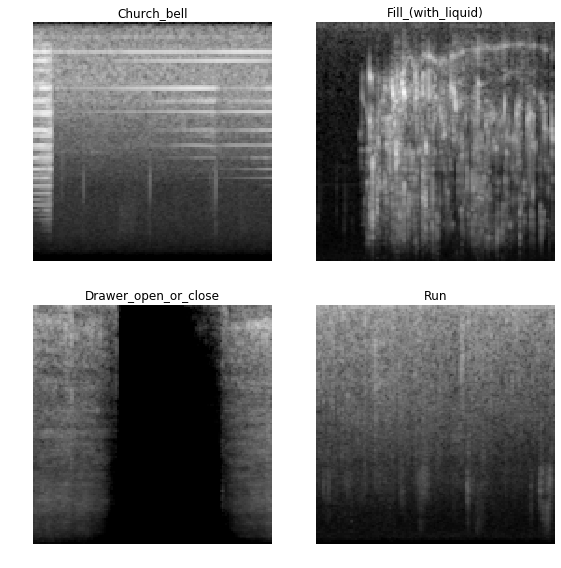

In [67]:
data.show_batch(2)

### Use cnn_learner method from fastai.vision library to create a learner object that will be used on the spectograms above. We are trying to find the best learning rate that fits the model here.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


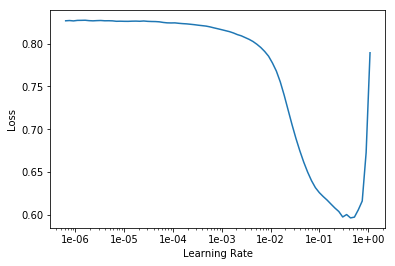

In [68]:
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
learn.unfreeze()

learn.lr_find();
learn.recorder.plot();

### We check for different values for learning rate, the most plausible value that helps in model fitting

In [69]:
learn.fit_one_cycle(5, 1e-1)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,lwlrap,time
0,0.201582,0.081113,0.095991,00:05
1,0.108429,0.083185,0.130152,00:06
2,0.085876,0.073305,0.164370,00:06
3,0.074956,0.067097,0.206753,00:07
4,0.068081,0.062653,0.286865,00:06


epoch,train_loss,valid_loss,lwlrap,time
0,0.063640,0.062158,0.307880,00:06
1,0.063535,0.063192,0.286583,00:05
2,0.063523,0.061708,0.298675,00:05
3,0.062919,0.061523,0.304185,00:05
4,0.061199,0.060133,0.335900,00:05
5,0.059085,0.056732,0.367521,00:05
6,0.056874,0.057343,0.378845,00:05
7,0.055202,0.075317,0.444712,00:05
8,0.053723,0.056097,0.457561,00:05
9,0.052419,0.051366,0.470008,00:05


### We can observe that with more epochs, the train_loss decreases and the lwlrap increases. We will test for different ranges of values to find which set of values are the most suitable in fitting the CNN.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


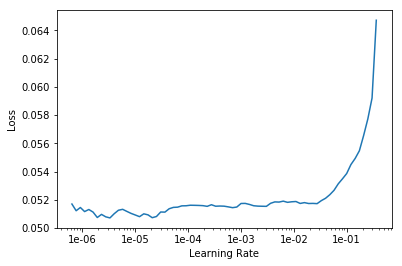

In [70]:
learn.lr_find(); learn.recorder.plot()

In [71]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,lwlrap,time
0,0.051873,0.050972,0.474893,00:06
1,0.051627,0.051145,0.463718,00:05
2,0.050993,0.052181,0.445176,00:05
3,0.051010,0.100620,0.456688,00:05
4,0.050657,0.050571,0.464714,00:05
5,0.050080,0.062263,0.454669,00:05
6,0.049101,0.048809,0.497651,00:05
7,0.047899,0.108080,0.501707,00:05
8,0.047142,0.045166,0.552453,00:05
9,0.045796,0.074573,0.544577,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


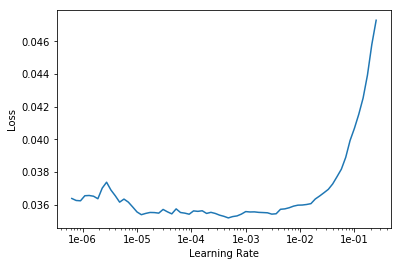

In [72]:
learn.lr_find(); learn.recorder.plot()

In [73]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,lwlrap,time
0,0.035530,0.039726,0.642899,00:06
1,0.035078,0.039200,0.639756,00:05
2,0.034994,0.039246,0.636912,00:05
3,0.035439,0.039502,0.636931,00:05
4,0.035133,0.039666,0.634491,00:05
5,0.035131,0.039829,0.634816,00:06
6,0.034575,0.039982,0.632692,00:06
7,0.033924,0.045757,0.620884,00:05
8,0.033420,0.038445,0.644875,00:05
9,0.033393,0.039132,0.645004,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


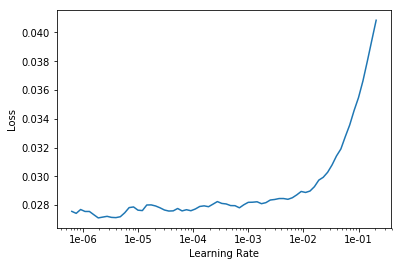

In [74]:
learn.lr_find(); learn.recorder.plot()

In [75]:
learn.fit_one_cycle(50, slice(1e-3, 3e-3))

epoch,train_loss,valid_loss,lwlrap,time
0,0.028287,0.036092,0.689257,00:05
1,0.028539,0.035683,0.673221,00:05
2,0.028495,0.036044,0.676667,00:05
3,0.028339,0.037222,0.676526,00:05
4,0.028428,0.035822,0.672935,00:05
5,0.028256,0.036362,0.679709,00:05
6,0.028572,0.037216,0.681607,00:05
7,0.028688,0.055815,0.662765,00:05
8,0.028332,0.037204,0.658666,00:05
9,0.028616,0.038504,0.669101,00:05


In [76]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,lwlrap,time
0,0.011692,0.037372,0.717386,00:05
1,0.011538,0.038012,0.727155,00:06
2,0.011889,0.036912,0.721933,00:06
3,0.011805,0.038350,0.719961,00:05
4,0.011636,0.038521,0.717311,00:05
5,0.011327,0.037635,0.723888,00:05
6,0.011273,0.039795,0.713023,00:05
7,0.011025,0.038661,0.722394,00:05
8,0.011252,0.038327,0.728244,00:05
9,0.010909,0.038841,0.729205,00:05


## Visualize the filters present in CNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


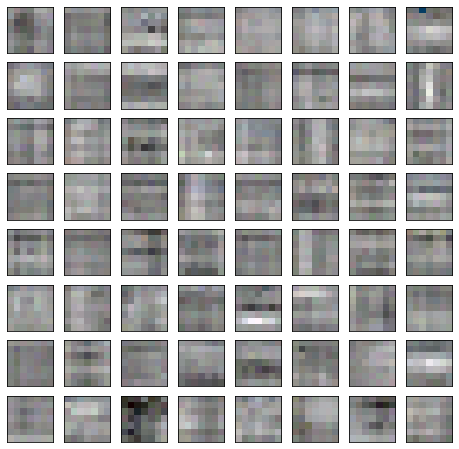

In [82]:
from sklearn.preprocessing import minmax_scale

def visualize_first_layer(learn, save_name=None):
    conv1 = list(learn.model.children())[0][0]
    if isinstance(conv1, torch.nn.modules.container.Sequential):
        conv1 = conv1[0] # for some models, 1 layer inside
    weights = conv1.weight.data.cpu().numpy()
    weights_shape = weights.shape
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.rollaxis(weights[i], 0, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save_name:
        fig.savefig(str(save_name))

visualize_first_layer(learn)

In [83]:
learn.save('fat2019_fastai_cnn2d_stage-2')
learn.export()

## Create a submission file

In [84]:
CUR_X_FILES, CUR_X = list(test_df.fname.values), X_test

test = ImageList.from_csv(WORK/'image', Path('../..')/CSV_SUBMISSION, folder='test')
learn = load_learner(WORK/'image', test=test)
preds, _ = learn.TTA(ds_type=DatasetType.Test) 

In [85]:
learn.data.classes

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation',
 'Bus',
 'Buzz',
 'Car_passing_by',
 'Cheering',
 'Chewing_and_mastication',
 'Child_speech_and_kid_speaking',
 'Chink_and_clink',
 'Chirp_and_tweet',
 'Church_bell',
 'Clapping',
 'Computer_keyboard',
 'Crackle',
 'Cricket',
 'Crowd',
 'Cupboard_open_or_close',
 'Cutlery_and_silverware',
 'Dishes_and_pots_and_pans',
 'Drawer_open_or_close',
 'Drip',
 'Electric_guitar',
 'Fart',
 'Female_singing',
 'Female_speech_and_woman_speaking',
 'Fill_(with_liquid)',
 'Finger_snapping',
 'Frying_(food)',
 'Gasp',
 'Glockenspiel',
 'Gong',
 'Gurgling',
 'Harmonica',
 'Hi-hat',
 'Hiss',
 'Keys_jangling',
 'Knock',
 'Male_singing',
 'Male_speech_and_man_speaking',
 'Marimba_and_xylophone',
 'Mechanical_fan',
 'Meow',
 'Microwave_oven',
 'Motorcycle',
 'Printer',
 'Purr',
 'Race_car_and_auto_racing',
 

In [86]:
test_df[learn.data.classes] = preds
test_df.to_csv('submission.csv', index=False)
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0.000017,4.957211e-08,7.655426e-08,4.309760e-06,0.000002,0.003011,1.819878e-07,1.281406e-04,0.000126,9.111455e-07,0.000007,0.000055,0.000003,1.741197e-05,1.437585e-02,4.362807e-06,0.000038,0.002682,0.000002,2.949590e-04,0.000059,0.001324,0.000234,3.163131e-05,4.716621e-06,0.000913,0.000009,1.550476e-04,0.001653,4.856985e-09,2.355506e-06,1.066238e-06,1.552990e-04,0.000722,6.829734e-05,0.000108,5.899618e-06,1.620020e-04,0.000002,...,1.452745e-05,1.353045e-03,0.088189,0.515897,3.187808e-07,5.653332e-07,4.179234e-07,1.287194e-07,0.000008,1.579049e-06,0.000004,0.000033,0.000046,6.957810e-07,1.301940e-07,1.769494e-04,0.000205,0.085184,1.520260e-04,0.068440,0.000017,0.000238,8.393439e-06,0.000008,3.721510e-04,0.000130,0.000138,5.863234e-09,0.000021,0.000027,0.000867,0.000002,3.688895e-04,2.442428e-04,0.000228,5.299786e-05,1.005708e-04,0.001447,1.107540e-04,3.227212e-03
1,0012633b.wav,0.068209,8.694149e-05,1.983406e-04,4.812185e-03,0.005927,0.001050,1.023339e-04,1.196936e-02,0.000179,1.251880e-03,0.004990,0.005936,0.006875,1.493555e-03,5.773605e-03,2.321765e-03,0.000642,0.005627,0.001593,6.751783e-04,0.000596,0.000155,0.001166,8.370757e-03,1.723875e-03,0.002133,0.002657,9.642729e-03,0.002239,1.482380e-04,9.246521e-05,9.067098e-04,1.769290e-03,0.008835,3.373356e-04,0.020270,4.185357e-04,1.730709e-04,0.001810,...,4.782971e-03,1.007321e-03,0.136533,0.000223,2.632641e-03,7.744425e-04,5.962143e-04,3.867998e-05,0.000931,7.055469e-03,0.009872,0.102550,0.004940,4.343483e-03,3.283585e-03,2.352174e-03,0.000311,0.003569,4.131315e-03,0.021620,0.002286,0.031734,8.255991e-03,0.002611,2.774552e-02,0.002738,0.001663,5.525880e-05,0.001137,0.000399,0.147110,0.003779,2.564362e-03,2.669580e-02,0.016831,2.192326e-03,1.245004e-02,0.003447,8.224636e-04,7.518468e-03
2,001ed5f1.wav,0.000596,7.195477e-08,2.558392e-06,9.265258e-07,0.000182,0.002064,3.355299e-06,3.019740e-03,0.000148,1.021936e-05,0.000256,0.000199,0.000058,1.169047e-06,1.369214e-02,7.301209e-05,0.000513,0.000362,0.000044,4.949805e-04,0.000375,0.000371,0.000003,1.240640e-05,1.005655e-02,0.007059,0.001475,1.202236e-01,0.000074,9.519759e-04,4.817496e-04,6.243046e-07,5.766283e-05,0.000106,5.413607e-05,0.000058,1.437974e-05,9.712230e-08,0.000007,...,1.797322e-06,1.425831e-03,0.000853,0.001947,6.253343e-03,5.429454e-06,8.287760e-04,1.282256e-06,0.000182,1.119743e-04,0.011892,0.000095,0.052253,3.041823e-04,1.290412e-04,3.776683e-04,0.138262,0.054346,8.014998e-07,0.001836,0.000003,0.000592,5.475947e-05,0.030549,1.558618e-03,0.068759,0.000042,1.920874e-06,0.004326,0.001867,0.000567,0.000131,1.460644e-05,1.043550e-01,0.000244,3.773181e-04,6.556379e-05,0.003050,3.716608e-06,1.794452e-02
3,00294be0.wav,0.000094,1.886235e-07,4.070549e-07,1.771349e-08,0.000454,0.000022,2.258444e-06,8.174217e-05,0.000495,2.299016e-04,0.000113,0.004140,0.000035,2.648558e-08,1.126179e-02,5.589966e-06,0.000022,0.000257,0.000017,6.984734e-08,0.001927,0.001973,0.0335

In [87]:
CUR_X_FILES, CUR_X = list(df.fname.values), X_train
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[lwlrap])
learn.load('fat2019_fastai_cnn2d_stage-2');

## Using Grad CAM method to visualize the CNN features

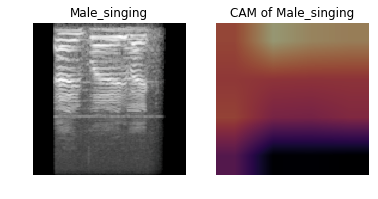

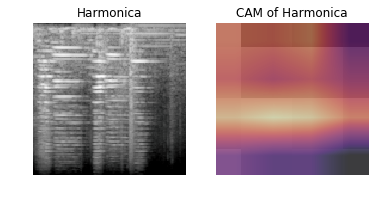

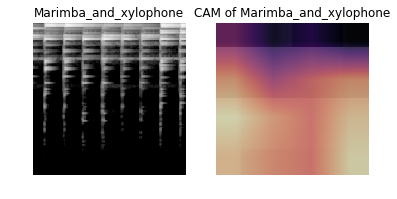

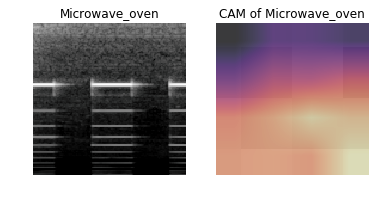

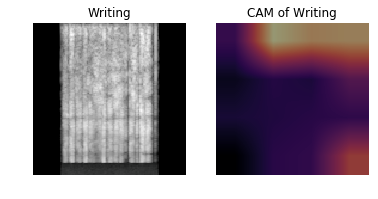

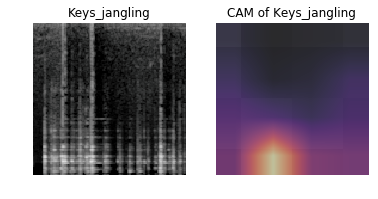

In [ ]:
from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]
        
    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()
    
    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a:
            with hook_output(m[0], grad = True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[0],img.shape[0],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()
        
    for y_i in np.where(y > 0)[0]:
        hook_a, hook_g = hooked_backward(cat = y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))
        
for idx in range(10):
    visualize_cnn_by_cam(learn, idx)